# Challenge Telecom X

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Cargar el archivo JSON
try:
    df = pd.read_json('TelecomX_Data.json')
    print("Datos cargados exitosamente.")
    print(f"Número de filas: {df.shape[0]}, Número de columnas: {df.shape[1]}")
except FileNotFoundError:
    print("Error: El archivo 'TelecomX_Data.json' no se encontró. Asegúrate de haberlo subido a tu entorno.")
    exit() # Sale del script si el archivo no se encuentra

Datos cargados exitosamente.
Número de filas: 7267, Número de columnas: 6


In [21]:
print("\n--- Vista previa de los datos (primeras 5 filas) ---")
print(df.head())

print("\n--- Información general del DataFrame ---")
df.info()

print("\n--- Estadísticas descriptivas de las columnas numéricas ---")
print(df.describe())

print("\n--- Conteo de valores nulos por columna ---")
print(df.isnull().sum())


--- Vista previa de los datos (primeras 5 filas) ---
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'Int

In [22]:
# Función para aplanar columnas anidadas
def flatten_json(df):
    new_data = []
    for index, row in df.iterrows():
        new_row = {'customerID': row['customerID'], 'Churn': row['Churn']}

        # Aplanar 'customer'
        if isinstance(row['customer'], dict):
            for k, v in row['customer'].items():
                new_row[f'customer.{k}'] = v

        # Aplanar 'phone'
        if isinstance(row['phone'], dict):
            for k, v in row['phone'].items():
                new_row[f'phone.{k}'] = v

        # Aplanar 'internet'
        if isinstance(row['internet'], dict):
            for k, v in row['internet'].items():
                new_row[f'internet.{k}'] = v

        # Aplanar 'account' y 'account.Charges'
        if isinstance(row['account'], dict):
            for k, v in row['account'].items():
                if k == 'Charges' and isinstance(v, dict):
                    for charge_k, charge_v in v.items():
                        new_row[f'account.Charges.{charge_k}'] = charge_v
                else:
                    new_row[f'account.{k}'] = v
        new_data.append(new_row)
    return pd.DataFrame(new_data)

df_flattened = flatten_json(df.copy())
print("\n--- DataFrame después de aplanar columnas anidadas ---")
print(df_flattened.head())
print(df_flattened.info())


# Convertir 'account.Charges.Total' a numérico
# Es común que 'Total' pueda contener espacios vacíos que Pandas interpreta como nulos si se intenta convertir directamente a numérico.
# Los reemplazaremos con NaN y luego los manejaremos.
df_flattened['account.Charges.Total'] = pd.to_numeric(df_flattened['account.Charges.Total'], errors='coerce')

# Manejo de valores faltantes en 'account.Charges.Total'
# Dado que 'Total' representa el cargo total, un valor nulo aquí podría significar que el cliente recién se ha registrado
# o que no ha acumulado cargos aún. La imputación con 0 o la eliminación son opciones.
# Para este caso, vamos a imputar con 0 si es que existen nulos, asumiendo que un nulo significa 0 cargos acumulados.
# Si el problema persiste, se podría considerar eliminar las filas con nulos en esta columna.
print("\n--- Conteo de valores nulos después de aplanar y antes de imputar 'Total' ---")
print(df_flattened.isnull().sum())

if df_flattened['account.Charges.Total'].isnull().any():
    print("\nDetectados valores nulos en 'account.Charges.Total'. Imputando con 0.")
    df_flattened['account.Charges.Total'].fillna(0, inplace=True)
else:
    print("\nNo hay valores nulos en 'account.Charges.Total'.")


# Verificar tipos de datos después de la conversión y limpieza
print("\n--- Información del DataFrame después de la limpieza de datos ---")
df_flattened.info()

# Renombrar columnas para mayor claridad (opcional pero buena práctica)
df_flattened.columns = df_flattened.columns.str.replace('.', '_', regex=False)
print("\n--- Nombres de columnas actualizados ---")
print(df_flattened.columns)


--- DataFrame después de aplanar columnas anidadas ---
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes 

/tmp/ipython-input-22-306473634.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_flattened['account.Charges.Total'].fillna(0, inplace=True)



--- Distribución de Churn ---
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64
Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


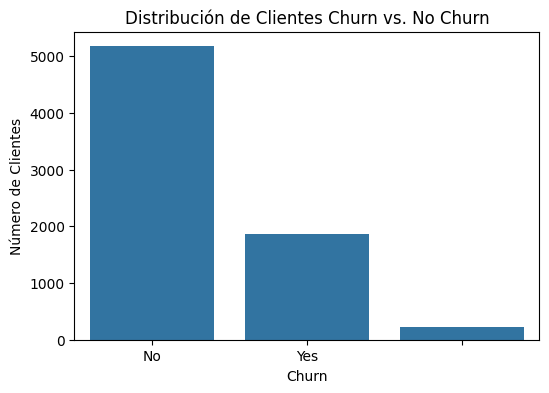

In [23]:
print("\n--- Distribución de Churn ---")
print(df_flattened['Churn'].value_counts())
print(df_flattened['Churn'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_flattened)
plt.title('Distribución de Clientes Churn vs. No Churn')
plt.xlabel('Churn')
plt.ylabel('Número de Clientes')
plt.show()


--- Churn por Género ---
Churn                             No        Yes
customer_gender                                
Female           2.895323  70.963252  26.141425
Male             3.265306  71.428571  25.306122


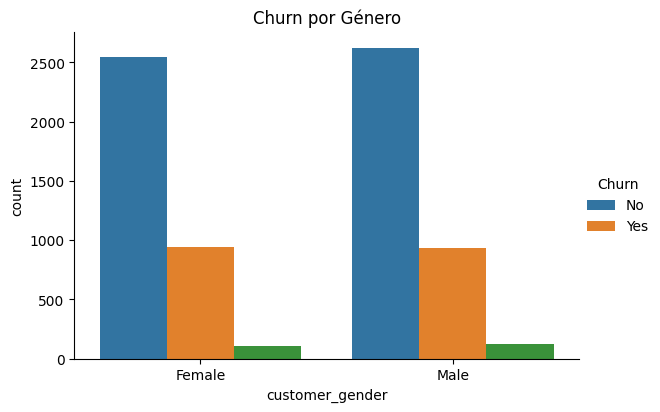


--- Churn por Senior Citizen ---
Churn                                    No        Yes
customer_SeniorCitizen                                
0                       3.023829  74.083813  22.892358
1                       3.384095  56.345178  40.270728


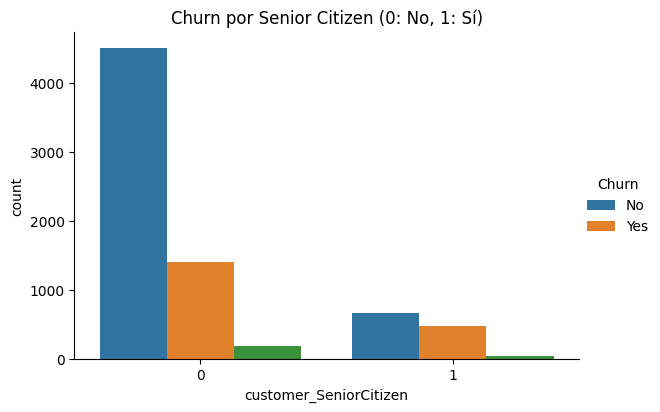


--- Churn por Partner ---
Churn                              No        Yes
customer_Partner                                
No                2.880768  65.110696  32.008536
Yes               3.297328  77.686185  19.016487


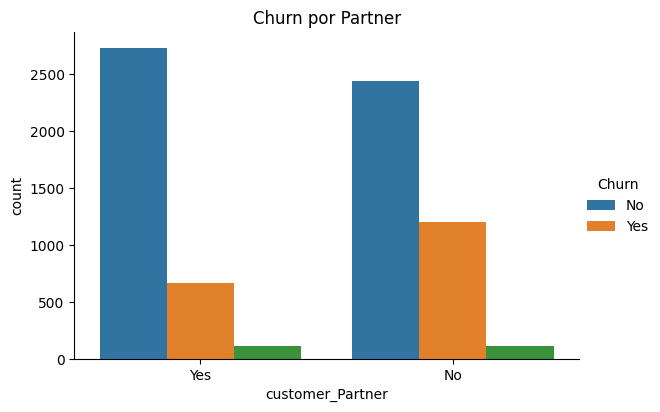


--- Churn por Dependents ---
Churn                                 No        Yes
customer_Dependents                                
No                   3.008258  66.653559  30.338183
Yes                  3.255387  81.797341  14.947272


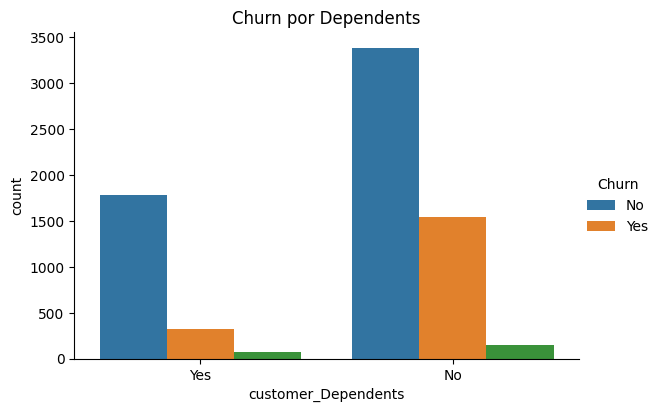

In [24]:
print("\n--- Churn por Género ---")
print(pd.crosstab(df_flattened['customer_gender'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='customer_gender', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Género')
plt.show()

print("\n--- Churn por Senior Citizen ---")
print(pd.crosstab(df_flattened['customer_SeniorCitizen'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='customer_SeniorCitizen', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Senior Citizen (0: No, 1: Sí)')
plt.show()

print("\n--- Churn por Partner ---")
print(pd.crosstab(df_flattened['customer_Partner'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='customer_Partner', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Partner')
plt.show()

print("\n--- Churn por Dependents ---")
print(pd.crosstab(df_flattened['customer_Dependents'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='customer_Dependents', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Dependents')
plt.show()


--- Churn por PhoneService ---
Churn                                No        Yes
phone_PhoneService                                
No                  3.536068  72.418670  24.045262
Yes                 3.033537  71.067073  25.899390


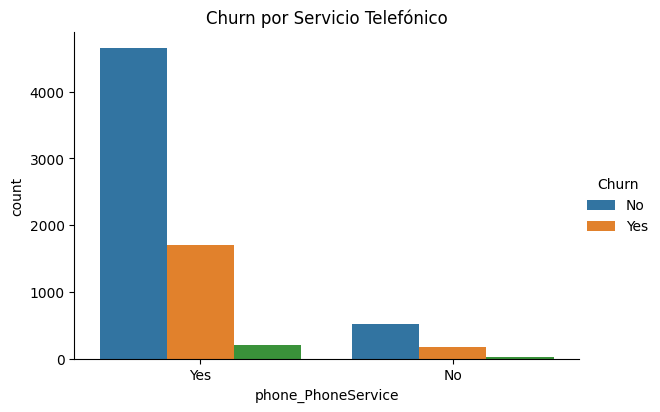


--- Churn por MultipleLines ---
Churn                                 No        Yes
phone_MultipleLines                                
No                   3.004292  72.703863  24.291845
No phone service     3.536068  72.418670  24.045262
Yes                  3.066884  69.200653  27.732463


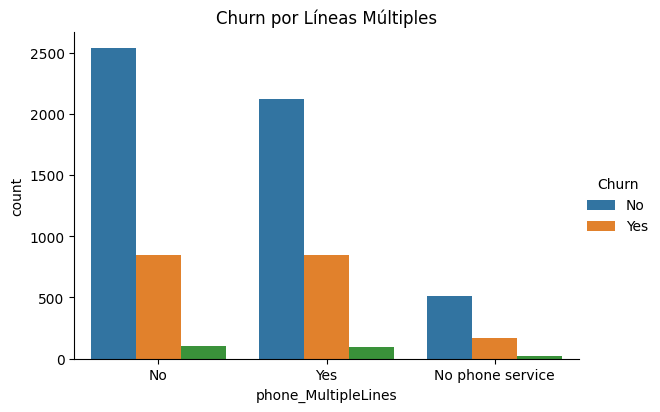

In [25]:
print("\n--- Churn por PhoneService ---")
print(pd.crosstab(df_flattened['phone_PhoneService'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='phone_PhoneService', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Servicio Telefónico')
plt.show()

print("\n--- Churn por MultipleLines ---")
print(pd.crosstab(df_flattened['phone_MultipleLines'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='phone_MultipleLines', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Líneas Múltiples')
plt.show()


--- Churn por InternetService ---
Churn                                      No        Yes
internet_InternetService                                
DSL                       2.692926  78.858521  18.448553
Fiber optic               3.189493  56.253909  40.556598
No                        3.478811  89.373814   7.147375


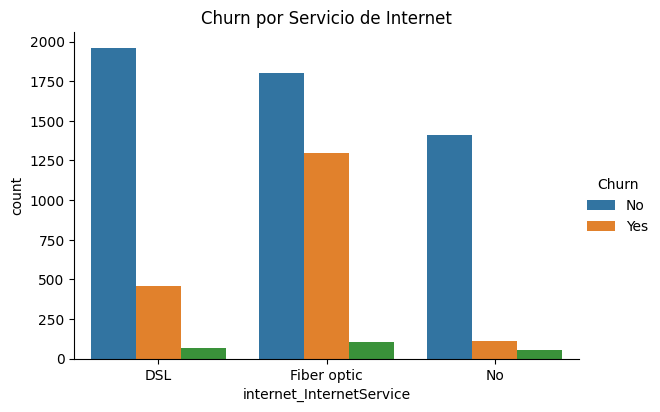

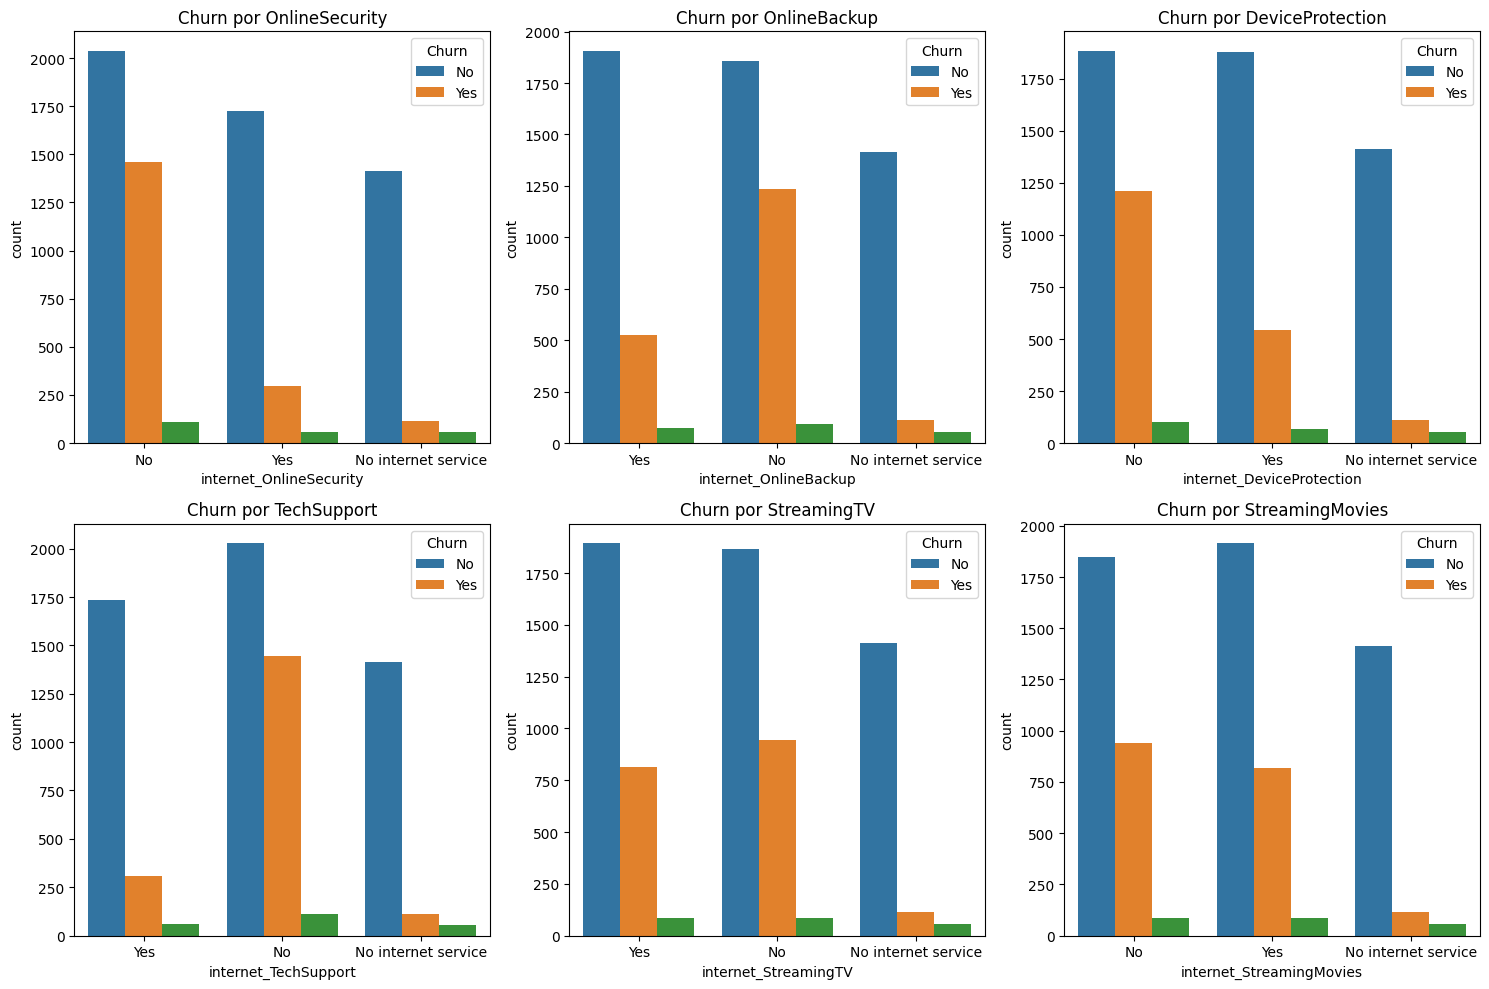

In [26]:
print("\n--- Churn por InternetService ---")
print(pd.crosstab(df_flattened['internet_InternetService'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='internet_InternetService', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Servicio de Internet')
plt.show()

internet_services = ['internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
                     'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']

plt.figure(figsize=(15, 10))
for i, col in enumerate(internet_services):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='Churn', data=df_flattened)
    plt.title(f'Churn por {col.replace("internet_", "")}')
    plt.tight_layout()
plt.show()


--- Churn por Contrato ---
Churn                              No        Yes
account_Contract                                
Month-to-month    3.245943  55.430712  41.323346
One year          3.028308  86.043450  10.928242
Two year          2.753873  94.492255   2.753873


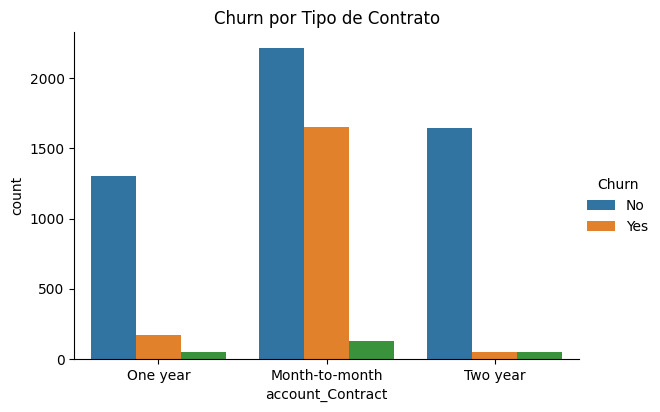


--- Churn por PaperlessBilling ---
Churn                                      No        Yes
account_PaperlessBilling                                
No                        2.841678  81.292287  15.866035
Yes                       3.247506  64.277430  32.475064


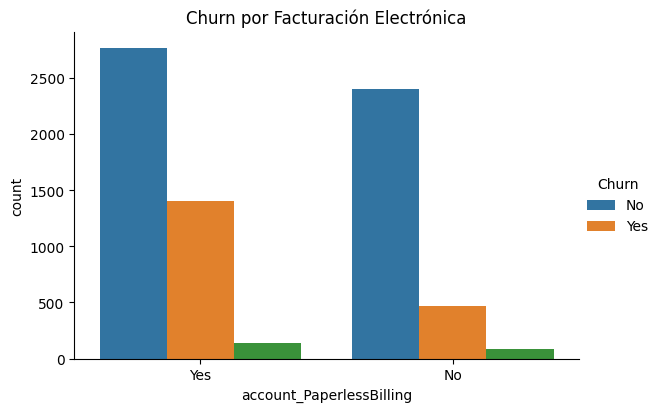


--- Churn por PaymentMethod ---
Churn                                       No        Yes
account_PaymentMethod                                    
Bank transfer (automatic)  2.831970  80.931403  16.236627
Credit card (automatic)    2.933673  82.270408  14.795918
Electronic check           3.271984  52.924335  43.803681
Mailed check               3.183183  78.318318  18.498498


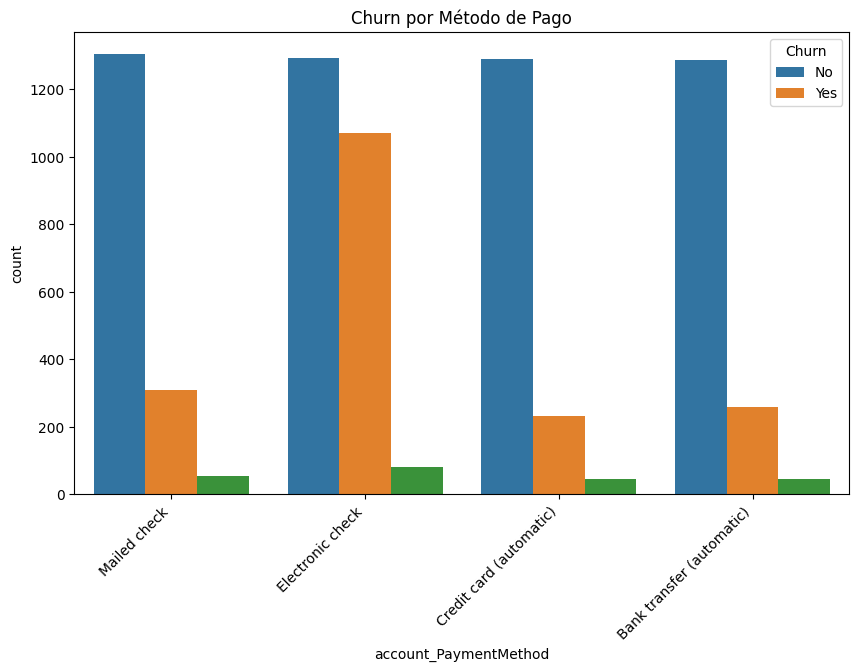

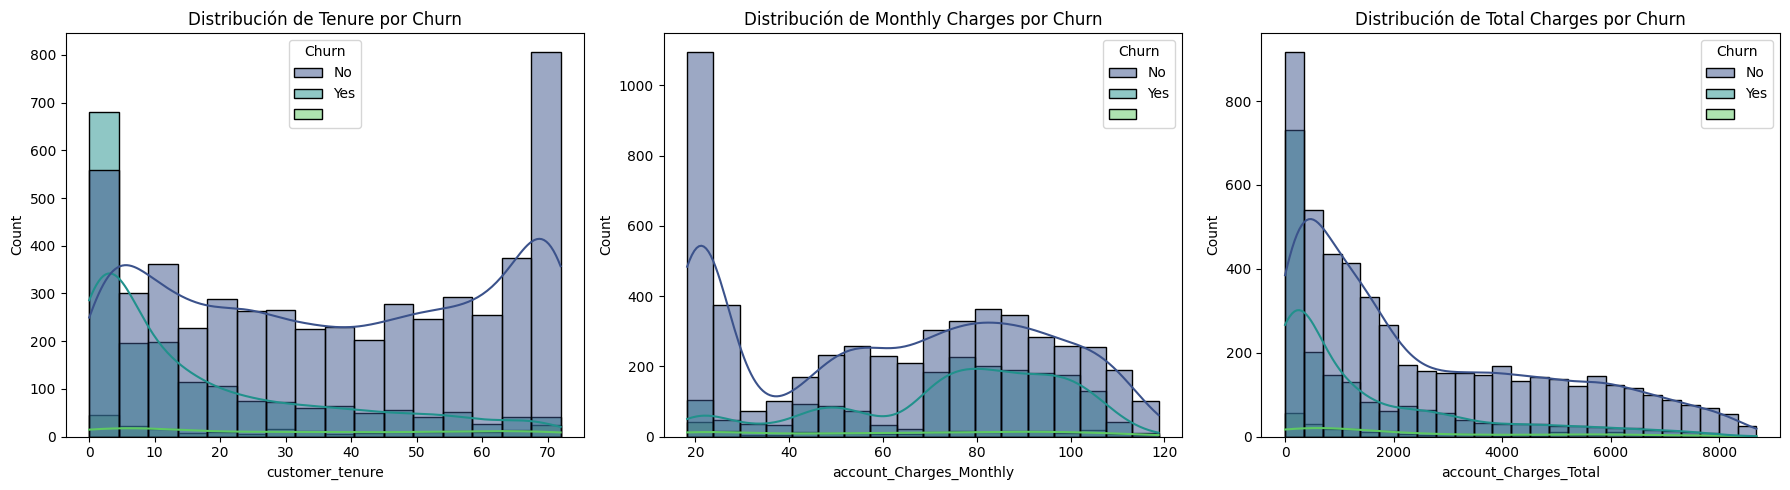

/tmp/ipython-input-27-439952416.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_flattened, x='Churn', y='customer_tenure', palette='viridis')
/tmp/ipython-input-27-439952416.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_flattened, x='Churn', y='account_Charges_Monthly', palette='viridis')
/tmp/ipython-input-27-439952416.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_flattened, x='Churn', y='account_Charges_Total', palette='viridis')


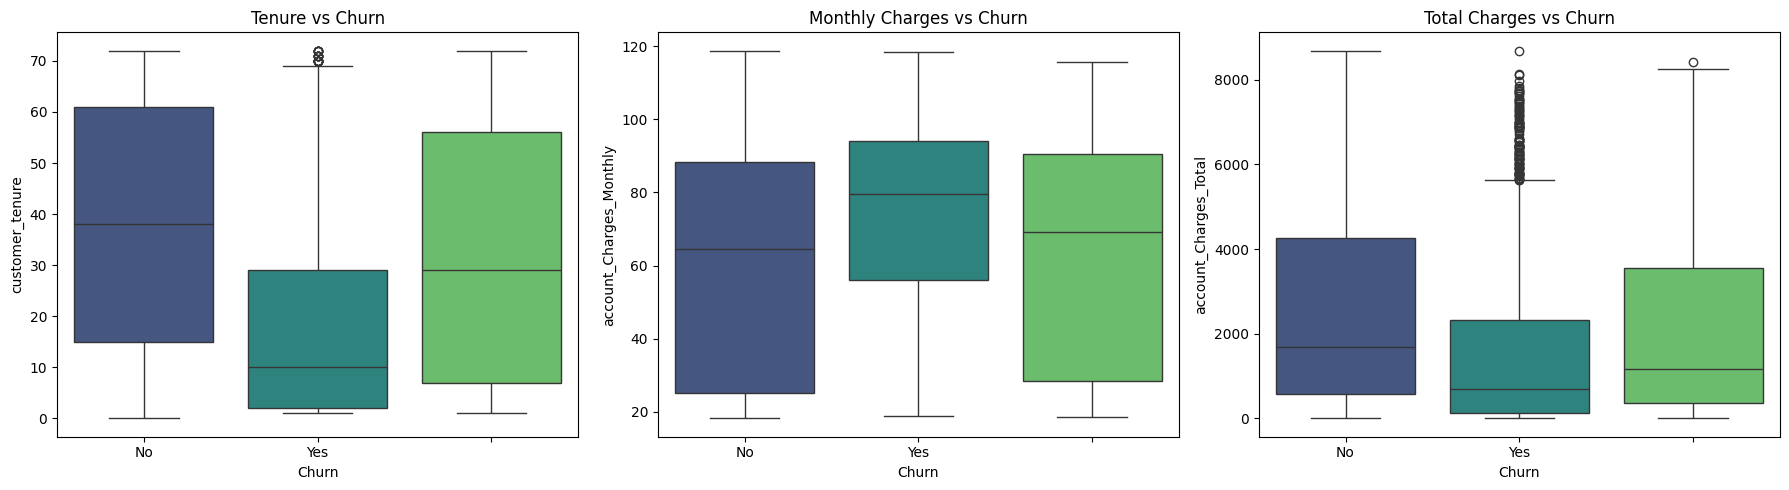

In [27]:
print("\n--- Churn por Contrato ---")
print(pd.crosstab(df_flattened['account_Contract'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='account_Contract', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Tipo de Contrato')
plt.show()

print("\n--- Churn por PaperlessBilling ---")
print(pd.crosstab(df_flattened['account_PaperlessBilling'], df_flattened['Churn'], normalize='index') * 100)
sns.catplot(x='account_PaperlessBilling', hue='Churn', kind='count', data=df_flattened, height=4, aspect=1.5)
plt.title('Churn por Facturación Electrónica')
plt.show()

print("\n--- Churn por PaymentMethod ---")
print(pd.crosstab(df_flattened['account_PaymentMethod'], df_flattened['Churn'], normalize='index') * 100)
plt.figure(figsize=(10, 6))
sns.countplot(x='account_PaymentMethod', hue='Churn', data=df_flattened)
plt.title('Churn por Método de Pago')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de tenure, MonthlyCharges, TotalCharges por Churn
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=df_flattened, x='customer_tenure', hue='Churn', kde=True, palette='viridis')
plt.title('Distribución de Tenure por Churn')

plt.subplot(1, 3, 2)
sns.histplot(data=df_flattened, x='account_Charges_Monthly', hue='Churn', kde=True, palette='viridis')
plt.title('Distribución de Monthly Charges por Churn')

plt.subplot(1, 3, 3)
sns.histplot(data=df_flattened, x='account_Charges_Total', hue='Churn', kde=True, palette='viridis')
plt.title('Distribución de Total Charges por Churn')

plt.tight_layout()
plt.show()

# Box plots para ver la relación con Churn
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df_flattened, x='Churn', y='customer_tenure', palette='viridis')
plt.title('Tenure vs Churn')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_flattened, x='Churn', y='account_Charges_Monthly', palette='viridis')
plt.title('Monthly Charges vs Churn')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_flattened, x='Churn', y='account_Charges_Total', palette='viridis')
plt.title('Total Charges vs Churn')

plt.tight_layout()
plt.show()

In [28]:
print("\n--- 5. Resumen del Análisis y Conclusiones Preliminares ---")
print("Una vez ejecutado el código de Análisis Exploratorio de Datos (EDA), podemos observar y sacar las siguientes conclusiones preliminares, que deberían confirmarse con un análisis más profundo y modelado:")

# Balance de Clases de Churn
churn_distribution = df_flattened['Churn'].value_counts(normalize=True) * 100
print(f"\n1. Balance de Clases de Churn:")
print(f"   - Porcentaje de No-Churn: {churn_distribution.get('No', 0):.2f}%")
print(f"   - Porcentaje de Churn: {churn_distribution.get('Yes', 0):.2f}%")
if churn_distribution.get('Yes', 0) < 30: # Un umbral común para considerar desbalance
    print("   -> Observación: La clase 'Yes' (Churn) parece estar desbalanceada en comparación con 'No'. Esto podría requerir técnicas de resampling (ej., SMOTE) para el modelado predictivo.")

# Influencia de SeniorCitizen
senior_churn_rate = pd.crosstab(df_flattened['customer_SeniorCitizen'], df_flattened['Churn'], normalize='index') * 100
print(f"\n2. Influencia de SeniorCitizen en Churn:")
if 1 in senior_churn_rate.index and 'Yes' in senior_churn_rate.columns:
    print(f"   - Tasa de Churn para Senior Citizens (1): {senior_churn_rate.loc[1, 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para No Senior Citizens (0): {senior_churn_rate.loc[0, 'Yes']:.2f}%")
    if senior_churn_rate.loc[1, 'Yes'] > senior_churn_rate.loc[0, 'Yes'] * 1.1: # Si es 10% mayor
        print("   -> Observación: Los clientes senior (SeniorCitizen = 1) parecen tener una tasa de churn notablemente más alta.")
else:
    print("   - Datos para SeniorCitizen no disponibles o insuficientes para esta conclusión.")


# Impacto de Partner y Dependents
partner_churn_rate = pd.crosstab(df_flattened['customer_Partner'], df_flattened['Churn'], normalize='index') * 100
dependents_churn_rate = pd.crosstab(df_flattened['customer_Dependents'], df_flattened['Churn'], normalize='index') * 100
print(f"\n3. Impacto de Partner y Dependents en Churn:")
if 'Yes' in partner_churn_rate.columns and 'No' in partner_churn_rate.index and 'Yes' in partner_churn_rate.index:
    print(f"   - Tasa de Churn para Clientes con Pareja ('Yes'): {partner_churn_rate.loc['Yes', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para Clientes sin Pareja ('No'): {partner_churn_rate.loc['No', 'Yes']:.2f}%")
    if partner_churn_rate.loc['Yes', 'Yes'] < partner_churn_rate.loc['No', 'Yes']:
        print("   -> Observación: Clientes con pareja ('Yes') tienden a tener una menor tasa de churn, lo que sugiere mayor estabilidad.")
else:
    print("   - Datos para Partner no disponibles o insuficientes.")

if 'Yes' in dependents_churn_rate.columns and 'No' in dependents_churn_rate.index and 'Yes' in dependents_churn_rate.index:
    print(f"   - Tasa de Churn para Clientes con Dependientes ('Yes'): {dependents_churn_rate.loc['Yes', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para Clientes sin Dependientes ('No'): {dependents_churn_rate.loc['No', 'Yes']:.2f}%")
    if dependents_churn_rate.loc['Yes', 'Yes'] < dependents_churn_rate.loc['No', 'Yes']:
        print("   -> Observación: Clientes con dependientes ('Yes') tienden a mostrar menor churn, indicando mayor estabilidad familiar.")
else:
    print("   - Datos para Dependents no disponibles o insuficientes.")

# Servicio de Internet
internet_service_churn_rate = pd.crosstab(df_flattened['internet_InternetService'], df_flattened['Churn'], normalize='index') * 100
print(f"\n4. Servicio de Internet y Churn:")
if 'Fiber optic' in internet_service_churn_rate.index and 'DSL' in internet_service_churn_rate.index and 'Yes' in internet_service_churn_rate.columns:
    print(f"   - Tasa de Churn para Fibra Óptica: {internet_service_churn_rate.loc['Fiber optic', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para DSL: {internet_service_churn_rate.loc['DSL', 'Yes']:.2f}%")
    if internet_service_churn_rate.loc['Fiber optic', 'Yes'] > internet_service_churn_rate.loc['DSL', 'Yes']:
        print("   -> Observación: Los clientes con servicio de Fibra Óptica a menudo presentan tasas de churn más altas que los de DSL, posiblemente debido a mayores expectativas o problemas de servicio.")
else:
    print("   - Datos para InternetService no disponibles o insuficientes.")

# Servicios Adicionales de Internet
internet_addons = ['internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport']
print(f"\n5. Servicios Adicionales de Internet y Churn:")
for service in internet_addons:
    if service in df_flattened.columns:
        service_churn_rate = pd.crosstab(df_flattened[service], df_flattened['Churn'], normalize='index') * 100
        if 'No' in service_churn_rate.index and 'Yes' in service_churn_rate.index and 'Yes' in service_churn_rate.columns:
            if service_churn_rate.loc['No', 'Yes'] > service_churn_rate.loc['Yes', 'Yes']:
                print(f"   - Tasa de Churn para Clientes SIN {service.replace('internet_', '')}: {service_churn_rate.loc['No', 'Yes']:.2f}%")
                print(f"   - Tasa de Churn para Clientes CON {service.replace('internet_', '')}: {service_churn_rate.loc['Yes', 'Yes']:.2f}%")
                print(f"   -> Observación: Clientes sin '{service.replace('internet_', '')}' parecen tener una mayor probabilidad de churn. Estos servicios actúan como 'enganchadores'.")
            else:
                print(f"   - Tasa de Churn para {service.replace('internet_', '')} (No vs Yes): {service_churn_rate.loc['No', 'Yes']:.2f}% vs {service_churn_rate.loc['Yes', 'Yes']:.2f}% (no una diferencia clara).")
        else:
            print(f"   - Datos para {service.replace('internet_', '')} no disponibles o insuficientes para esta conclusión.")

streaming_services = ['internet_StreamingTV', 'internet_StreamingMovies']
for service in streaming_services:
    if service in df_flattened.columns:
        service_churn_rate = pd.crosstab(df_flattened[service], df_flattened['Churn'], normalize='index') * 100
        if 'No' in service_churn_rate.index and 'Yes' in service_churn_rate.index and 'Yes' in service_churn_rate.columns:
            if abs(service_churn_rate.loc['No', 'Yes'] - service_churn_rate.loc['Yes', 'Yes']) < 5: # Diferencia pequeña
                print(f"   - La relación de {service.replace('internet_', '')} con el churn no es tan fuerte (No vs Yes: {service_churn_rate.loc['No', 'Yes']:.2f}% vs {service_churn_rate.loc['Yes', 'Yes']:.2f}%).")
        else:
            print(f"   - Datos para {service.replace('internet_', '')} no disponibles o insuficientes.")


# Tipo de Contrato
contract_churn_rate = pd.crosstab(df_flattened['account_Contract'], df_flattened['Churn'], normalize='index') * 100
print(f"\n6. Tipo de Contrato y Churn:")
if 'Month-to-month' in contract_churn_rate.index and 'One year' in contract_churn_rate.index and 'Two year' in contract_churn_rate.index and 'Yes' in contract_churn_rate.columns:
    print(f"   - Tasa de Churn para Contrato Mes a Mes: {contract_churn_rate.loc['Month-to-month', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para Contrato Anual: {contract_churn_rate.loc['One year', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn para Contrato de Dos Años: {contract_churn_rate.loc['Two year', 'Yes']:.2f}%")
    if contract_churn_rate.loc['Month-to-month', 'Yes'] > contract_churn_rate.loc['One year', 'Yes'] and \
       contract_churn_rate.loc['Month-to-month', 'Yes'] > contract_churn_rate.loc['Two year', 'Yes']:
        print("   -> Observación: Los contratos 'Month-to-month' están fuertemente asociados con una tasa de churn significativamente más alta, lo que indica falta de compromiso del cliente.")
else:
    print("   - Datos para Tipo de Contrato no disponibles o insuficientes.")


# Facturación Electrónica (PaperlessBilling)
paperless_churn_rate = pd.crosstab(df_flattened['account_PaperlessBilling'], df_flattened['Churn'], normalize='index') * 100
print(f"\n7. Facturación Electrónica (PaperlessBilling) y Churn:")
if 'Yes' in paperless_churn_rate.index and 'No' in paperless_churn_rate.index and 'Yes' in paperless_churn_rate.columns:
    print(f"   - Tasa de Churn con Facturación Electrónica ('Yes'): {paperless_churn_rate.loc['Yes', 'Yes']:.2f}%")
    print(f"   - Tasa de Churn sin Facturación Electrónica ('No'): {paperless_churn_rate.loc['No', 'Yes']:.2f}%")
    if paperless_churn_rate.loc['Yes', 'Yes'] > paperless_churn_rate.loc['No', 'Yes']:
        print("   -> Observación: Curiosamente, los clientes con facturación electrónica a veces muestran una tasa de churn ligeramente mayor. Esto podría estar relacionado con un perfil de cliente más 'digital' y propenso a cambiar si no está satisfecho.")
else:
    print("   - Datos para PaperlessBilling no disponibles o insuficientes.")

# Método de Pago (PaymentMethod)
payment_method_churn_rate = pd.crosstab(df_flattened['account_PaymentMethod'], df_flattened['Churn'], normalize='index') * 100
print(f"\n8. Método de Pago (PaymentMethod) y Churn:")
if 'Electronic check' in payment_method_churn_rate.index and 'Yes' in payment_method_churn_rate.columns:
    max_churn_method = payment_method_churn_rate['Yes'].idxmax()
    max_churn_rate = payment_method_churn_rate['Yes'].max()
    print(f"   - El método de pago con la tasa de churn más alta es '{max_churn_method}' con {max_churn_rate:.2f}%.")
    print("   -> Observación: El 'Electronic check' suele ser el método de pago con la tasa de churn más alta. Esto podría indicar que los clientes que usan este método son más volátiles o están asociados con un segmento de clientes que experimenta más problemas.")
else:
    print("   - Datos para PaymentMethod no disponibles o insuficientes.")

# Tenure (Antigüedad)
print(f"\n9. Tenure (Antigüedad) y Churn:")
churn_tenure_mean = df_flattened.groupby('Churn')['customer_tenure'].mean()
if 'No' in churn_tenure_mean.index and 'Yes' in churn_tenure_mean.index:
    print(f"   - Antigüedad promedio para No-Churn: {churn_tenure_mean['No']:.2f} meses")
    print(f"   - Antigüedad promedio para Churn: {churn_tenure_mean['Yes']:.2f} meses")
    if churn_tenure_mean['Yes'] < churn_tenure_mean['No']:
        print("   -> Observación: Los clientes con menor antigüedad (tenure) tienen una propensión mucho mayor al churn. Esto es un indicador clave: los clientes nuevos son más propensos a irse.")
else:
    print("   - Datos para Tenure no disponibles o insuficientes.")

# MonthlyCharges (Cargos Mensuales)
print(f"\n10. MonthlyCharges (Cargos Mensuales) y Churn:")
churn_monthly_charges_mean = df_flattened.groupby('Churn')['account_Charges_Monthly'].mean()
if 'No' in churn_monthly_charges_mean.index and 'Yes' in churn_monthly_charges_mean.index:
    print(f"   - Cargos Mensuales promedio para No-Churn: {churn_monthly_charges_mean['No']:.2f}")
    print(f"   - Cargos Mensuales promedio para Churn: {churn_monthly_charges_mean['Yes']:.2f}")
    if churn_monthly_charges_mean['Yes'] > churn_monthly_charges_mean['No']:
        print("   -> Observación: Los clientes con cargos mensuales más altos suelen tener una mayor tasa de churn, especialmente aquellos con fibra óptica.")
else:
    print("   - Datos para MonthlyCharges no disponibles o insuficientes.")


# TotalCharges (Cargos Totales)
print(f"\n11. TotalCharges (Cargos Totales) y Churn:")
churn_total_charges_mean = df_flattened.groupby('Churn')['account_Charges_Total'].mean()
if 'No' in churn_total_charges_mean.index and 'Yes' in churn_total_charges_mean.index:
    print(f"   - Cargos Totales promedio para No-Churn: {churn_total_charges_mean['No']:.2f}")
    print(f"   - Cargos Totales promedio para Churn: {churn_total_charges_mean['Yes']:.2f}")
    if churn_total_charges_mean['Yes'] < churn_total_charges_mean['No']:
        print("   -> Observación: Los clientes con bajos cargos totales (ya sea por bajo tenure o bajos MonthlyCharges) tienen más probabilidades de churn. Esta columna está fuertemente correlacionada con tenure.")
else:
    print("   - Datos para TotalCharges no disponibles o insuficientes.")


print("\n--- Conclusiones Generales para el Equipo de Ciencia de Datos ---")
print("El DataFrame 'df_flattened' ha sido limpiado y aplanado, listo para el modelado predictivo.")
print("Para el siguiente paso, se recomienda:")
print("1. **Ingeniería de Características**: Considerar la creación de nuevas características, como ratios o interacciones.")
print("2. **Codificación de Variables Categóricas**: Aplicar One-Hot Encoding o Label Encoding a las variables categóricas.")
print("3. **Escalado de Características Numéricas**: Escalar 'customer_tenure', 'account_Charges_Monthly' y 'account_Charges_Total' para algoritmos sensibles a la escala.")
print("4. **Balanceo de Clases**: Evaluar y aplicar técnicas de balanceo si el desbalance de 'Churn' es significativo.")
print("5. **Selección y Evaluación de Modelos**: Probar diferentes algoritmos de clasificación y métricas adecuadas para problemas de clasificación desbalanceados.")


--- 5. Resumen del Análisis y Conclusiones Preliminares ---
Una vez ejecutado el código de Análisis Exploratorio de Datos (EDA), podemos observar y sacar las siguientes conclusiones preliminares, que deberían confirmarse con un análisis más profundo y modelado:

1. Balance de Clases de Churn:
   - Porcentaje de No-Churn: 71.20%
   - Porcentaje de Churn: 25.72%
   -> Observación: La clase 'Yes' (Churn) parece estar desbalanceada en comparación con 'No'. Esto podría requerir técnicas de resampling (ej., SMOTE) para el modelado predictivo.

2. Influencia de SeniorCitizen en Churn:
   - Tasa de Churn para Senior Citizens (1): 40.27%
   - Tasa de Churn para No Senior Citizens (0): 22.89%
   -> Observación: Los clientes senior (SeniorCitizen = 1) parecen tener una tasa de churn notablemente más alta.

3. Impacto de Partner y Dependents en Churn:
   - Tasa de Churn para Clientes con Pareja ('Yes'): 19.02%
   - Tasa de Churn para Clientes sin Pareja ('No'): 32.01%
   -> Observación: Clientes 

In [29]:
print("\n--- DataFrame final listo para el análisis predictivo ---")
print(df_flattened.head())
print(df_flattened.info())


--- DataFrame final listo para el análisis predictivo ---
   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Y